# Part I - Flights analysis
## by Nadav Oved

## Introduction
> This is a flights analysis based on a dataset containing various flight metrics. I chose to focus on the various carriers and their performance (e.g, delay - wise, popularity - wise, etc...), therefore I included features that are relevant to this direction. 

## Preliminary Wrangling

### Getting the data

To get the data, either run `gather.py` located in root folder, or add the data manually to the `data` folder. Then run `load.py` for various optimizations.

### *NOTE - initally planned to just use unsampled datasets, but visualization operations are taking way too long.*

3. sample each year seperately, then concatenate selected years.

### Exploration

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [1]:
from load import get_years
#More info within module.

In [3]:
df = get_years(year_range=(2000, 2008))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Year               9000 non-null   category
 1   Month              9000 non-null   category
 2   DayOfMonth         9000 non-null   category
 3   DayOfWeek          9000 non-null   category
 4   UniqueCarrier      9000 non-null   category
 5   ActualElapsedTime  8784 non-null   float32 
 6   AirTime            8784 non-null   float32 
 7   ArrDelay           8784 non-null   float32 
 8   DepDelay           8808 non-null   float32 
 9   Origin             9000 non-null   category
 10  Dest               9000 non-null   category
 11  Distance           9000 non-null   float32 
 12  Cancelled          9000 non-null   boolean 
 13  Diverted           9000 non-null   boolean 
 14  route              9000 non-null   category
dtypes: boolean(2), category(8), float32(5)
memory usage: 41

The function bellow helps with excluding outliers from plots:

In [5]:
def drop_outliers(data, value_col, p=5, category_col=None):
    """Return DataFrame without overflow values."""
    def trunc(frame):  
        top, bottom = np.nanpercentile(a=frame[value_col], q=[100 - p / 2, p / 2])
        return frame[(frame[value_col] >= bottom) & (frame[value_col] <= top)].copy()
    if category_col:
        if data[category_col].dtype != 'category':
            raise TypeError('Category_col dtype should be categorical.')
        objs = [trunc(data[data[category_col] == item]) for item in data[category_col].cat.categories]
        return pd.concat(objs, ignore_index=True)
    else:
        return trunc(data)

In [6]:
df = get_years(year_range=(2000, 2008)) # loads about ~3mins, but final dataset is very light.

### 1. Distribution of departure delays in for each carrier in 2000-2008 (95% of data)

<AxesSubplot: xlabel='UniqueCarrier', ylabel='DepDelay'>

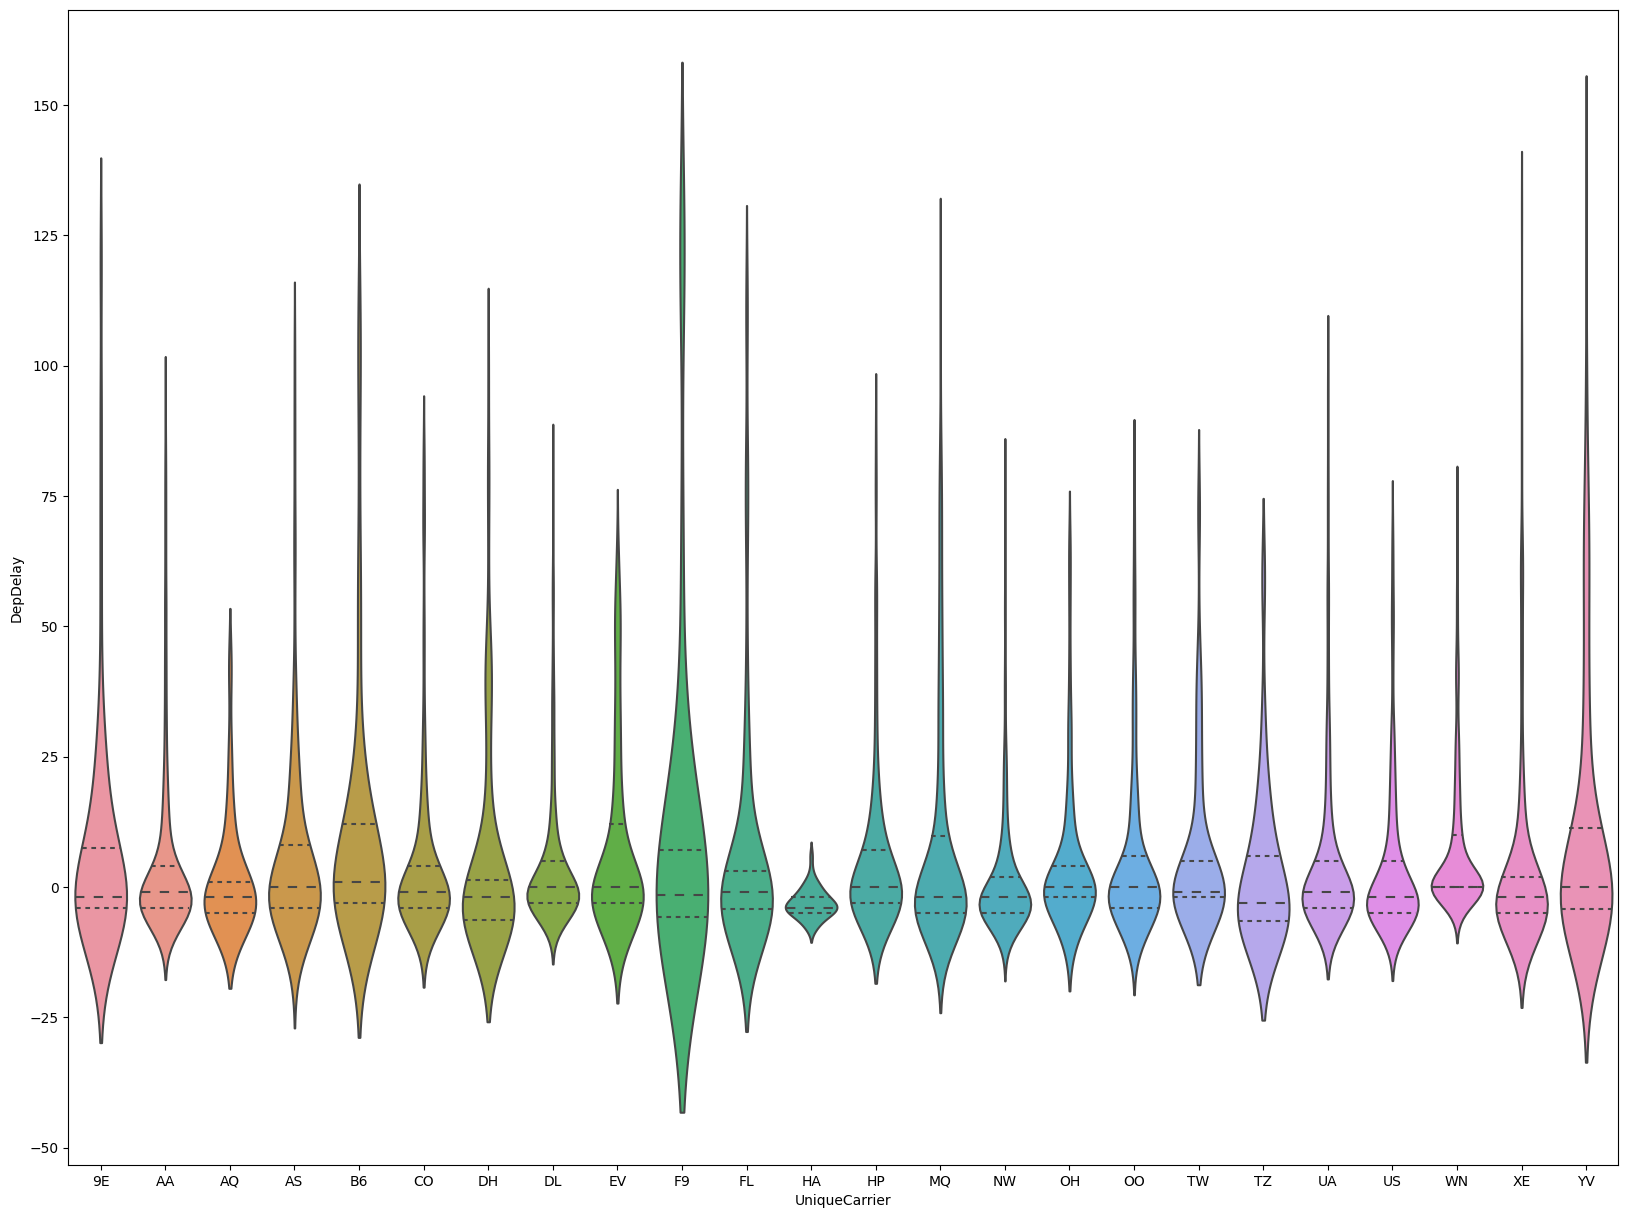

In [8]:
fig = plt.figure(figsize=(20, 15))
chart_data = drop_outliers(df, value_col='DepDelay', category_col='UniqueCarrier')
sns.violinplot(data=chart_data, x='UniqueCarrier', y='DepDelay', inner='quartile', scale='width')

<mark>Findings: looking at all carriers, there are mostly right - skewed distributions. They are unimodal, and most samples are very close to zero, which is a positive finding about delays.

### 2. Distribution of departure delay combined with arrival delay (%90 of data)

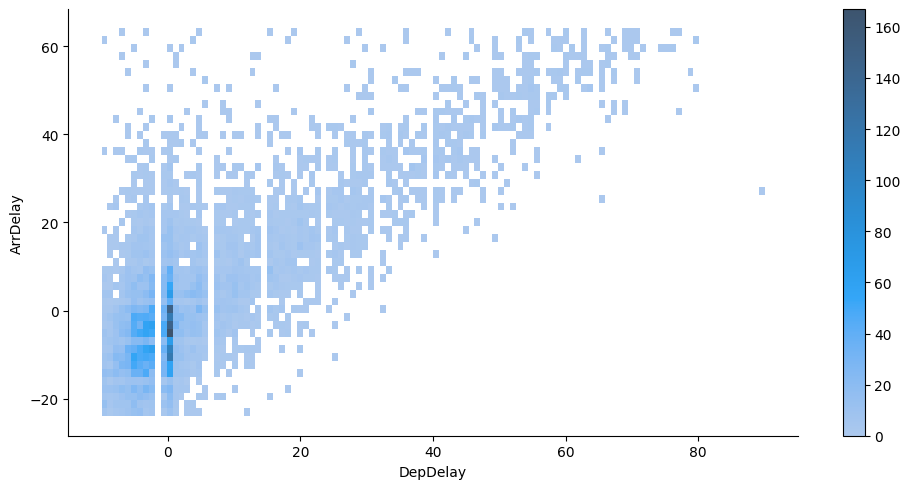

In [9]:
chart_data = drop_outliers(drop_outliers(df, 'DepDelay'), 'ArrDelay')
sns.displot(data=chart_data, x='DepDelay', y='ArrDelay', cbar=True, aspect=2)

<mark>Findings: Most common delay combination is (0,0), followed by values that are close to zero, which is a good thing for delays. Please note that this plot is not meant to provide any information about relationship between arrival and departure delays, but rather provide info about overall distribution of the two variables.

### 3. Most common routes

<BarContainer object of 10 artists>

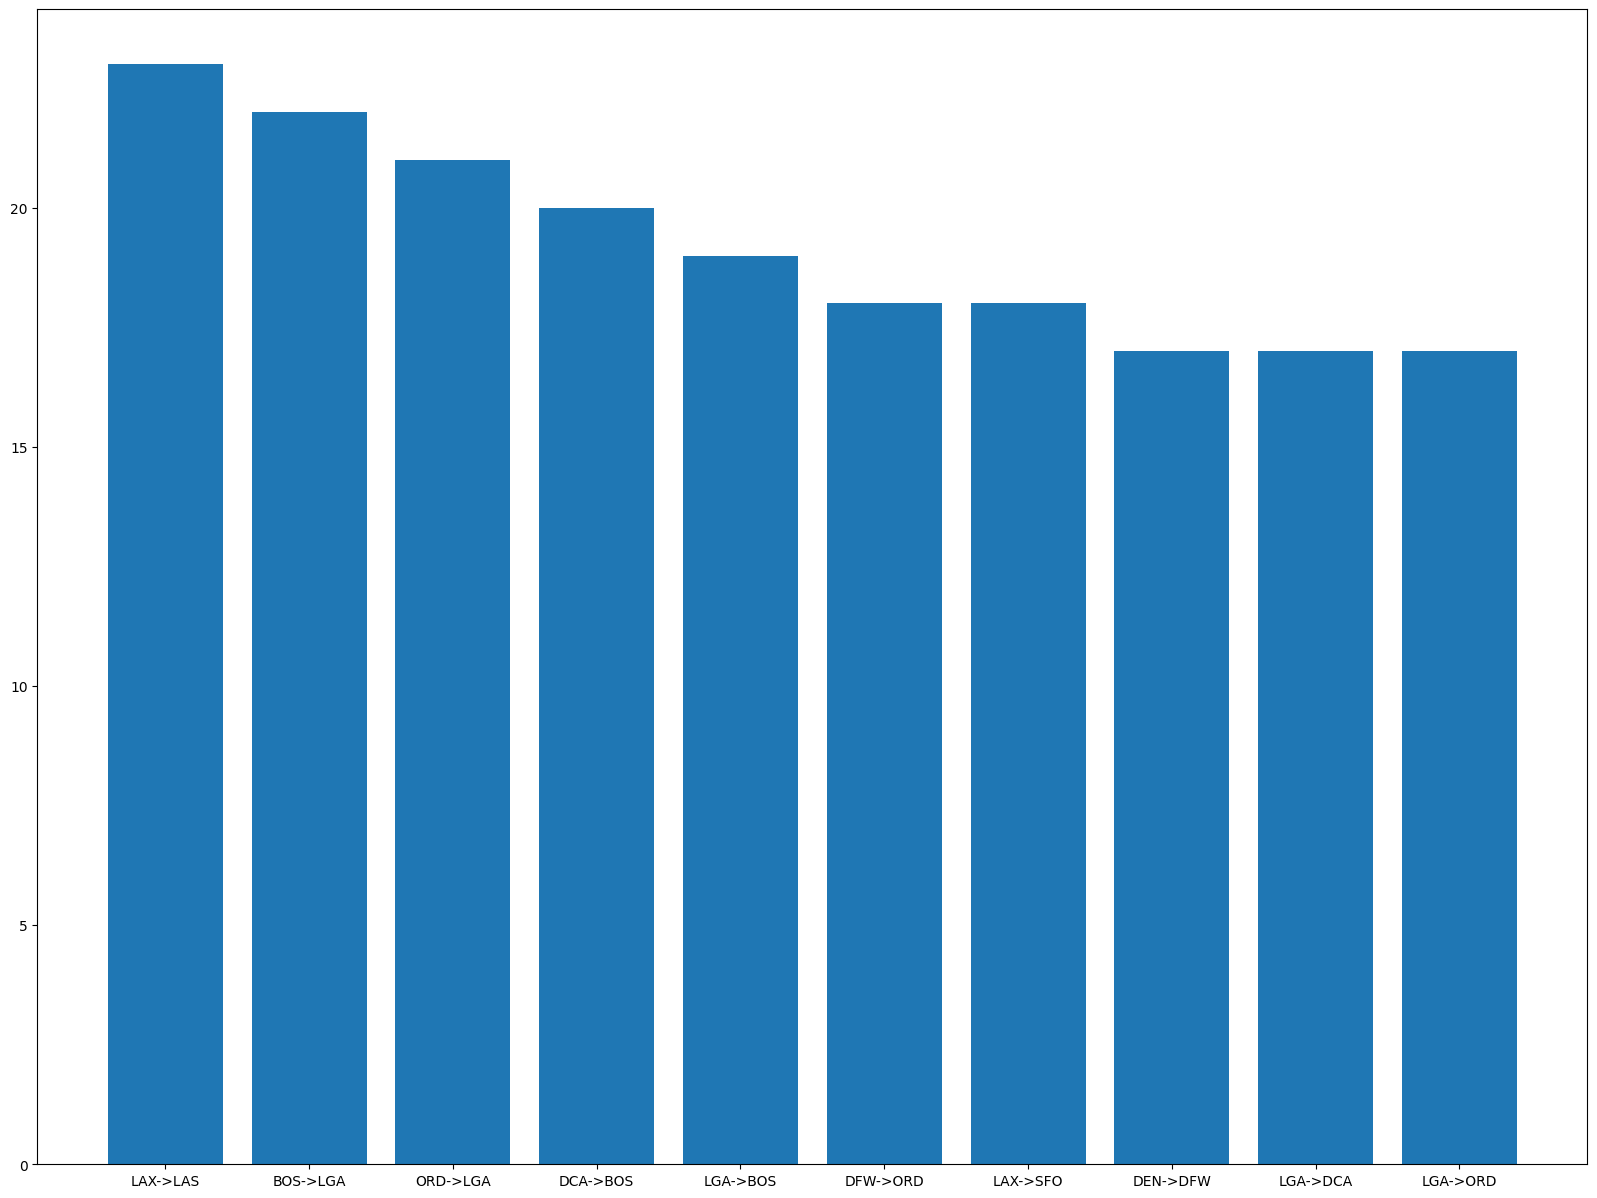

In [10]:
fig = plt.figure(figsize=(20, 15))
routes = df.groupby('route', as_index=False).size()
chart_data = routes.nlargest(n=10, columns='size')
plt.bar(x=chart_data['route'], height=chart_data['size'])

<mark>Findings: By looking at the graph, we can clearly see the top 10 flight routes.

### 4. yearly flight counts faceted by carrier

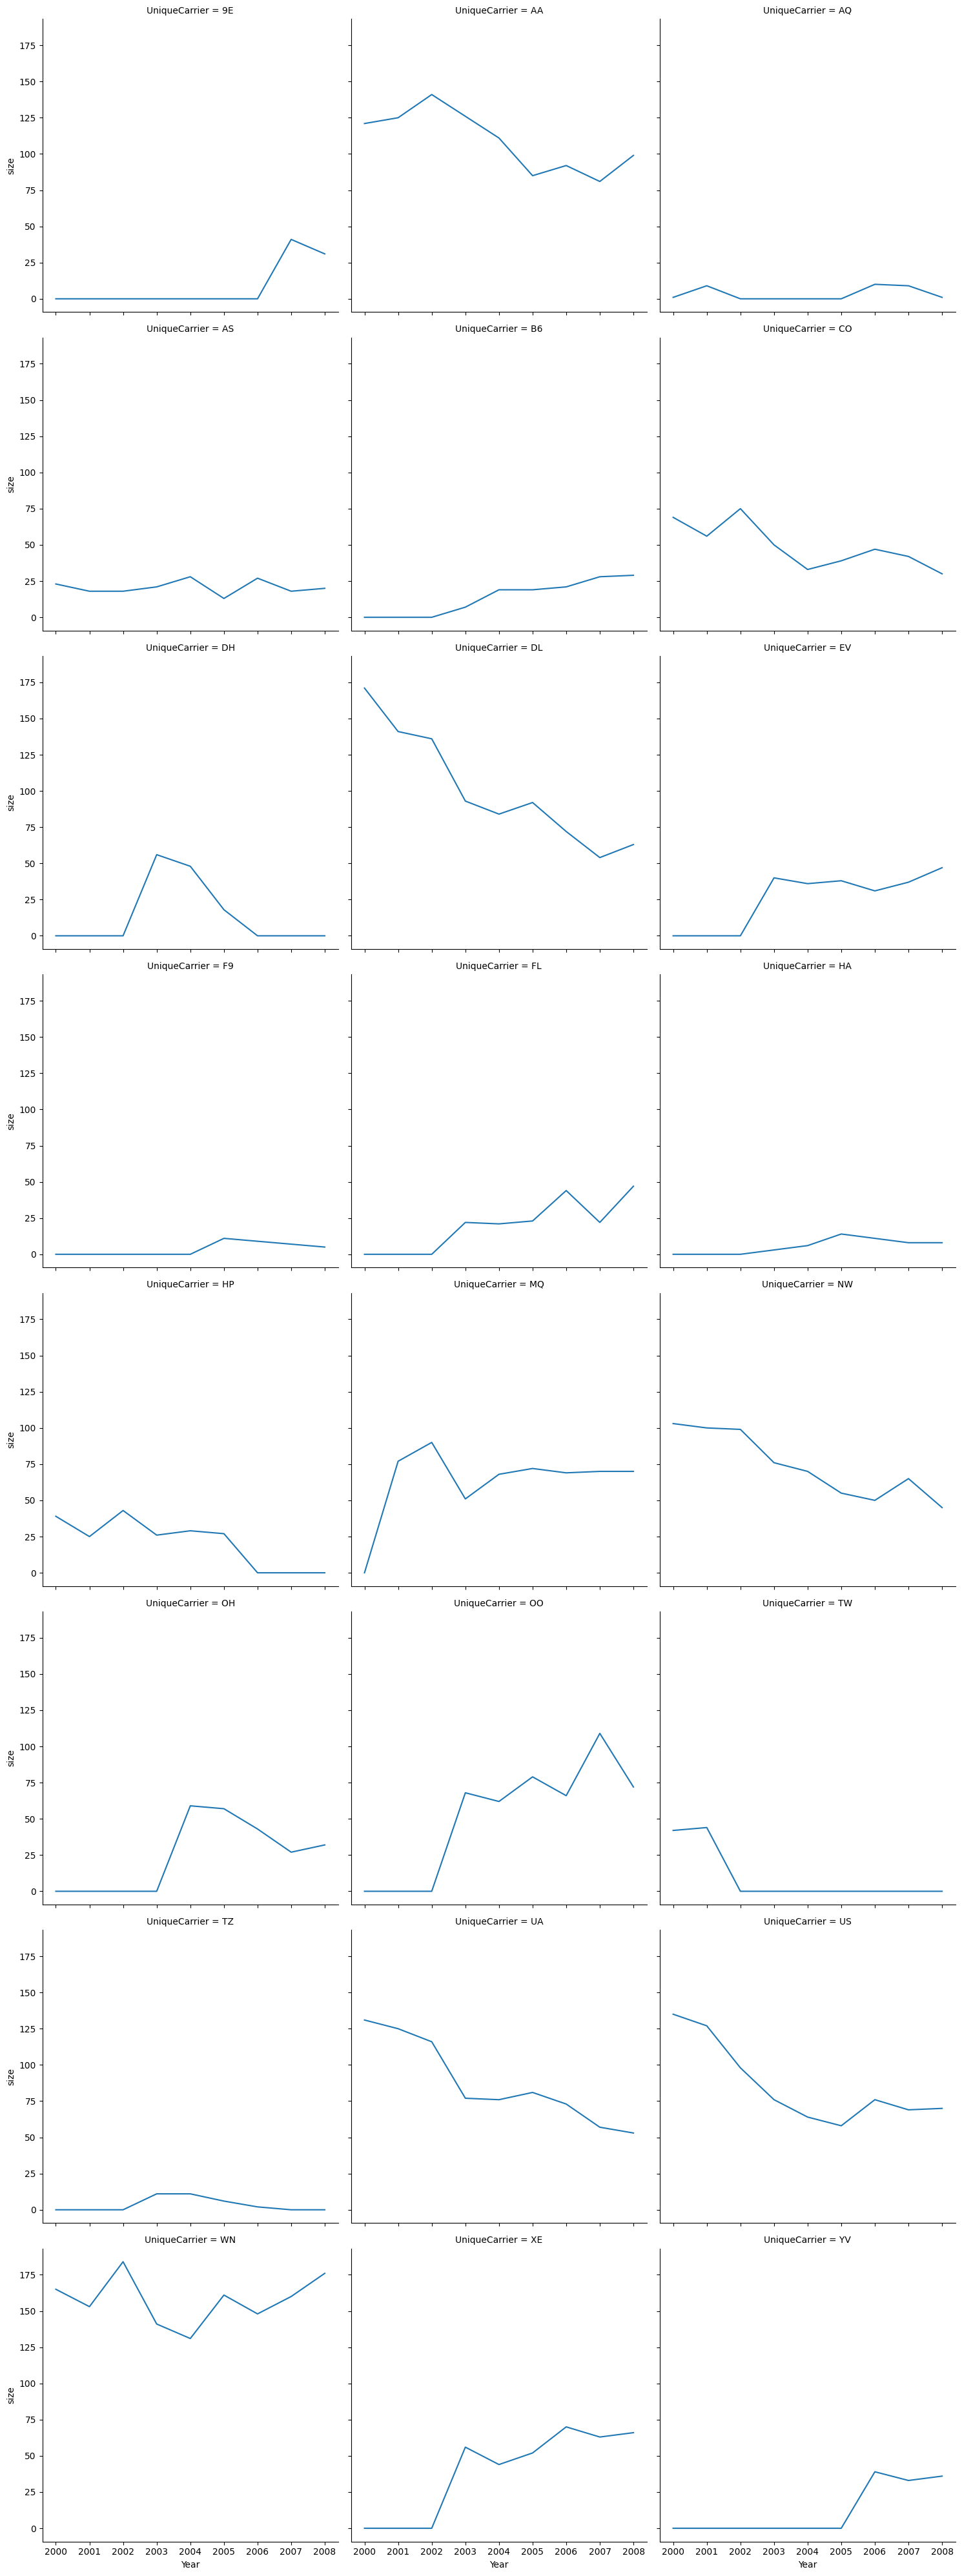

In [11]:
chart_data = df.groupby(['Year', 'UniqueCarrier'], as_index=False).size()
sns.relplot(data=chart_data, kind='line',x='Year',y='size', col='UniqueCarrier', col_wrap=3)

<mark>Findings: Overall, Carrier `WN` was the most popular across all years, with many carriers have very low yearly flight counts across all years. Others, like `DL`, reduced dramaticaly over the years. In contrast there's `XE`, that mostly managed to increase through the years.

### 5. Monthly activity for each UniqueCarrier (by flight counts)

<AxesSubplot: xlabel='Month', ylabel='UniqueCarrier'>

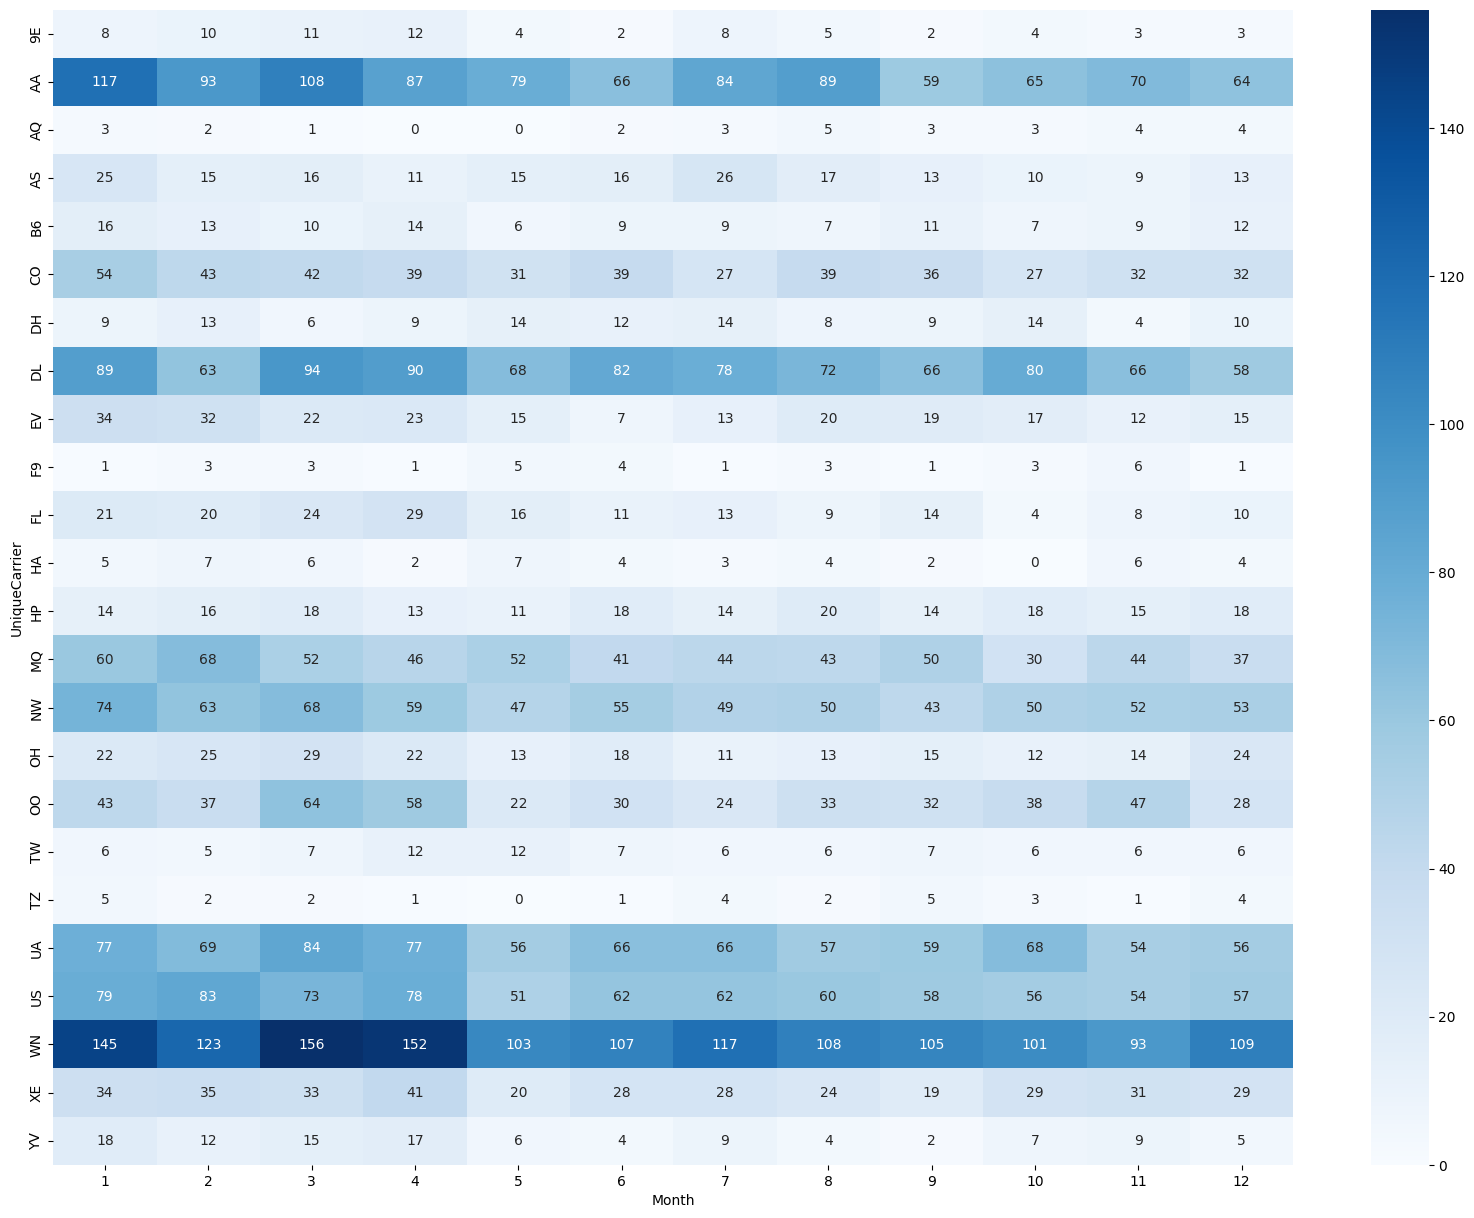

In [12]:
routes_cnts = df.groupby(by=['UniqueCarrier', 'Month'], as_index=False).size()
chart_data = routes_cnts.pivot(index='UniqueCarrier', columns='Month', values='size')
ordered_cols = chart_data.columns.sort_values()
chart_data = chart_data.reindex(columns=ordered_cols)
fig = plt.figure(figsize=(20, 15))
sns.heatmap(data=chart_data, annot=True, fmt=".0f", cmap='Blues')

<mark>Findings: The most popular carrier overall is `WN`, as seen by its extremely blue - shaded cells across all months. For example, its most popular month is March, followed by April.

### 6. Average air times for each UniqueCarrier

<AxesSubplot: xlabel='UniqueCarrier', ylabel='AirTime'>

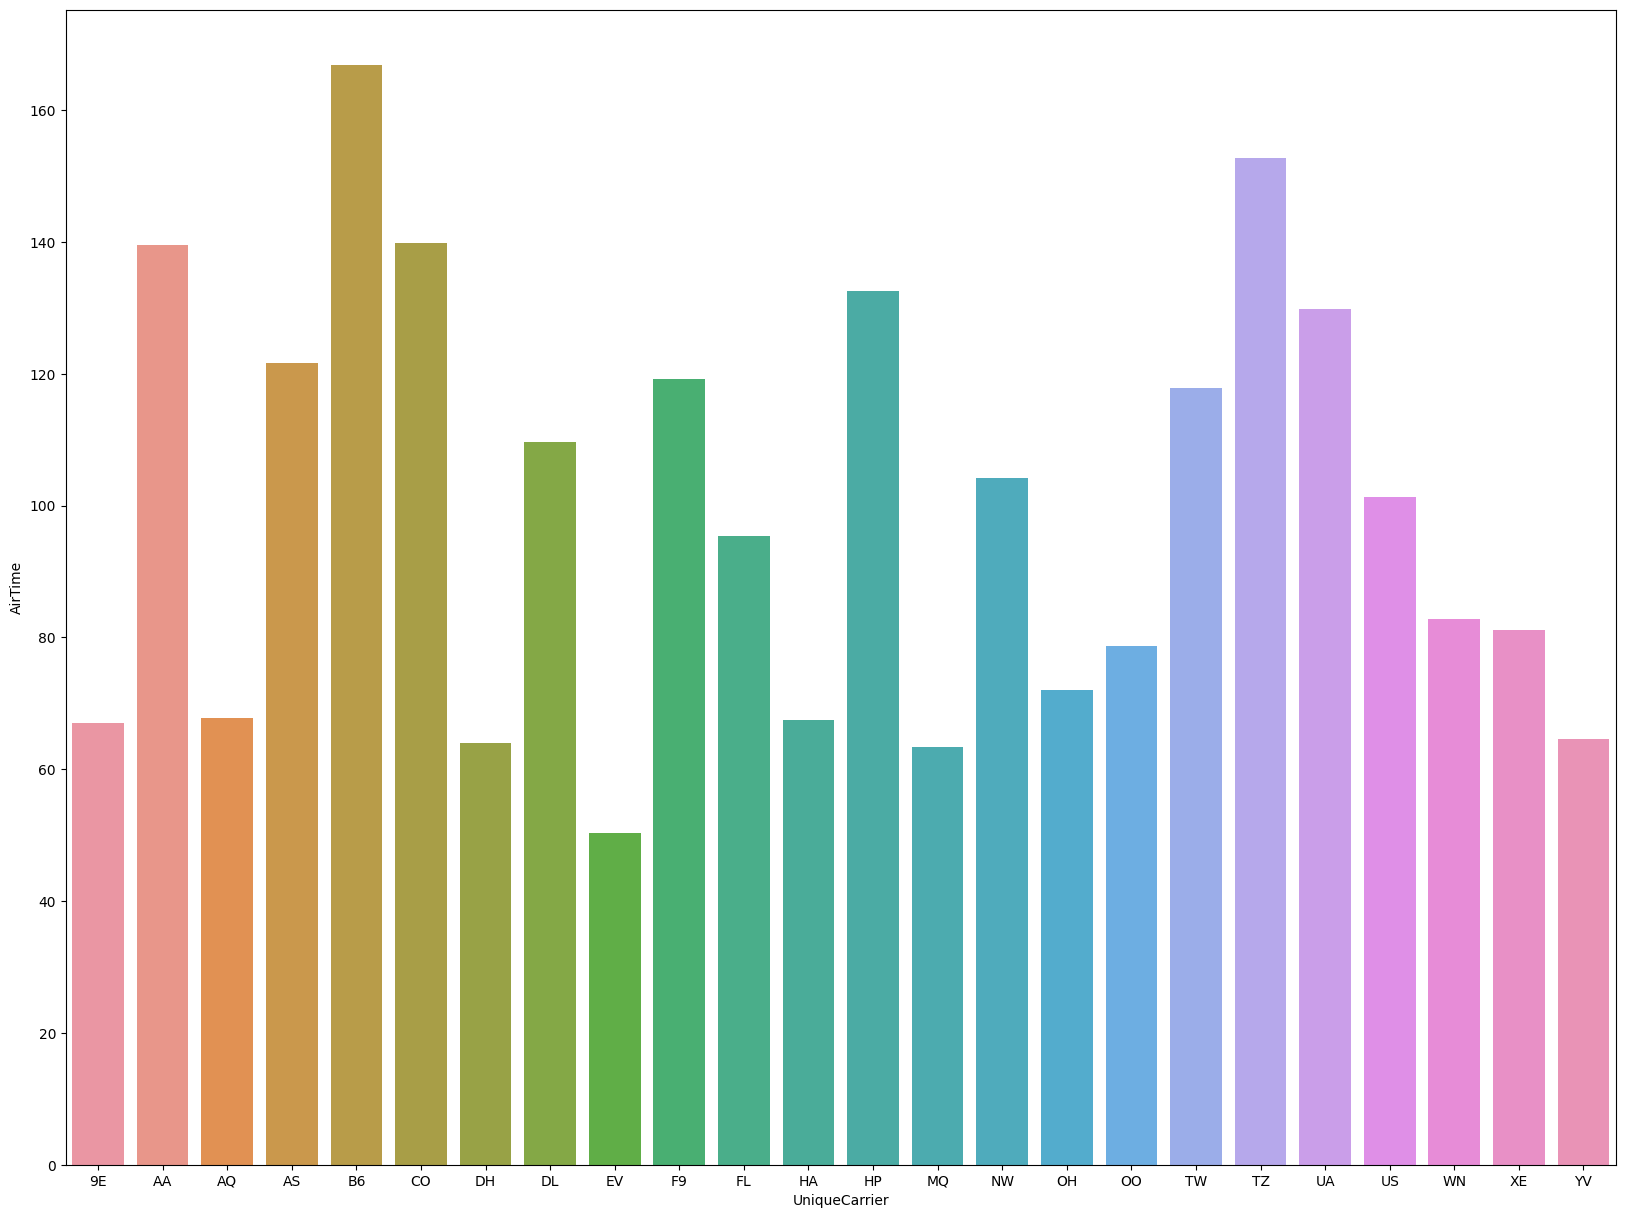

In [25]:
fig = plt.figure(figsize=(20, 15))
sns.barplot(data=df, x='UniqueCarrier', y='AirTime', errorbar=None)

<mark>Findings: It is noticable that the avg. airtime per flight for most carriers is bellow 80. On the other hand, `B6` and `TZ` top the chart with above 150 minutes.


### 7. DepDelay vs ArrDelay (95% of data)

<AxesSubplot: xlabel='DepDelay', ylabel='ArrDelay'>

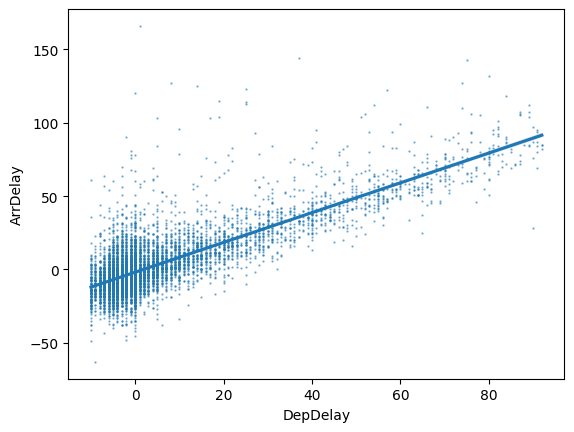

In [14]:
chart_data = drop_outliers(data=df, value_col='DepDelay')
sns.regplot(data=chart_data, x='DepDelay', y='ArrDelay', scatter_kws={'s':0.5, 'alpha':0.5})

<mark>Findings: Coming back to the heatmap describing these two variables, the correlation between them wasn't noticable. In contrast, here there's a very noticable relatively strong correlation between them. Most values are concentrated around  (0,0), as better described within the heatmap before.

### 8. Distribution of total delay time for each day of the week (95% of data).

<mark>Using total delay time enables us to aggragate both delay types as one,and therefore to measure flight performance more concisely across various facets:

In [5]:
def get_ttl_delays():
    """Compute total delay time. Negative values treated as zeroes"""
    res = []
    for n in df.index:
        temp = sum(item if item > 0 else 0 for item 
                   in (df.loc[n, 'ArrDelay'], df.loc[n, 'DepDelay']))
        res.append(temp)
    return pd.Series(res)

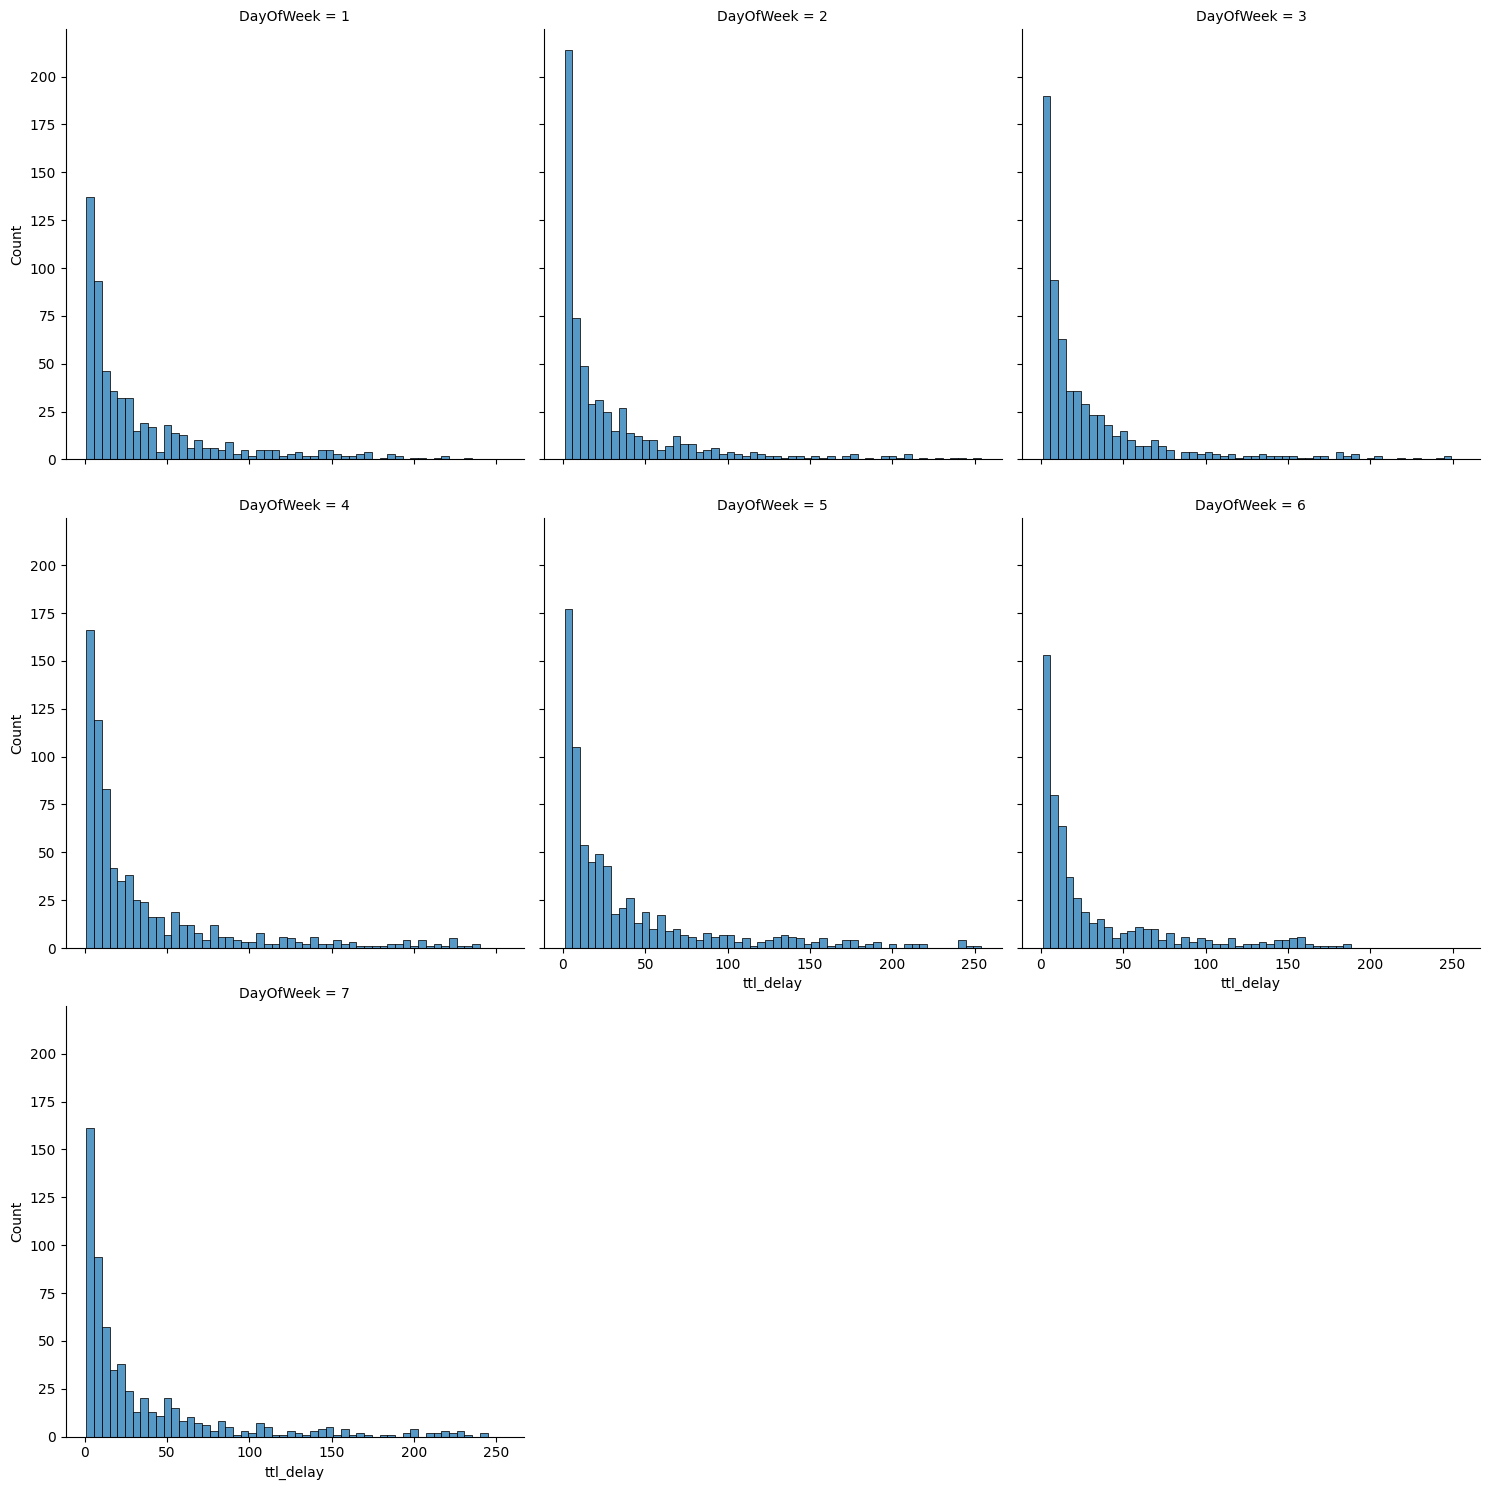

In [48]:
temp = df.copy()
temp['ttl_delay'] = get_ttl_delays()
chart_data = drop_outliers(temp[temp['ttl_delay'] > 0], value_col='ttl_delay', category_col='DayOfWeek')
sns.displot(data=chart_data, x='ttl_delay', col='DayOfWeek', col_wrap=3)

<mark>Findings: In all weekdays, there's a right - skewed distribution of total delay time, where the mode is around 0 total delay time - another positive finding about flight delays.

### 9. total delay time by year

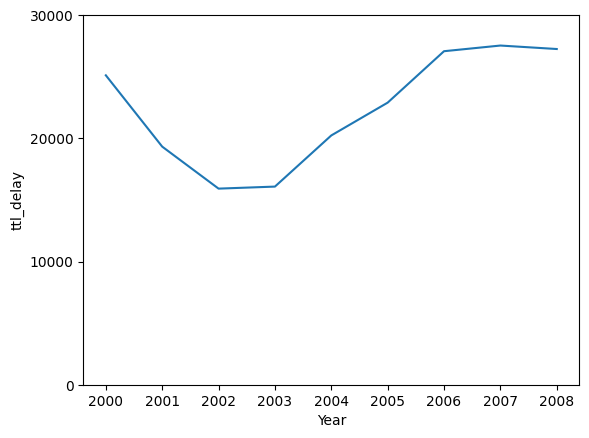

In [17]:
data = temp.groupby('Year')['ttl_delay'].sum()
sns.lineplot(data=data)
plt.yticks(np.arange(0, int(data.max()) + 10_000, 10_000))
plt.show()

<mark>Findings: 2002 - 2003 were the most "on - time" years for the flights within the dataset. In contrast, there's 2006 - 2008, which had the most delay.

### 10. Airtime vs Distance (95% of data)

<AxesSubplot: xlabel='Distance', ylabel='AirTime'>

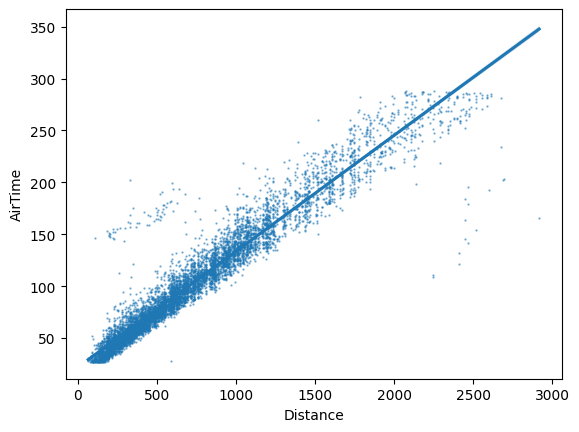

In [24]:
chart_data = drop_outliers(df, value_col='AirTime')
sns.regplot(data=chart_data, x='Distance', y='AirTime', scatter_kws={'s': 0.5, 'alpha': 0.5})

<mark>Findings: There's a strong correlation between airtime and flight distance. Most values are shorter flights in terms of time and distance, and have very low spread, while the larger values are more spread - out and are scarcer.

### 11. Mean Ground Time prop for each UniqueCarrier

<mark>Ground time proportion for each flight is very useful in observing how much time of a given flight is actually spent within airports, which isn't given directly in the dataset, but actually can be calculated very easily.

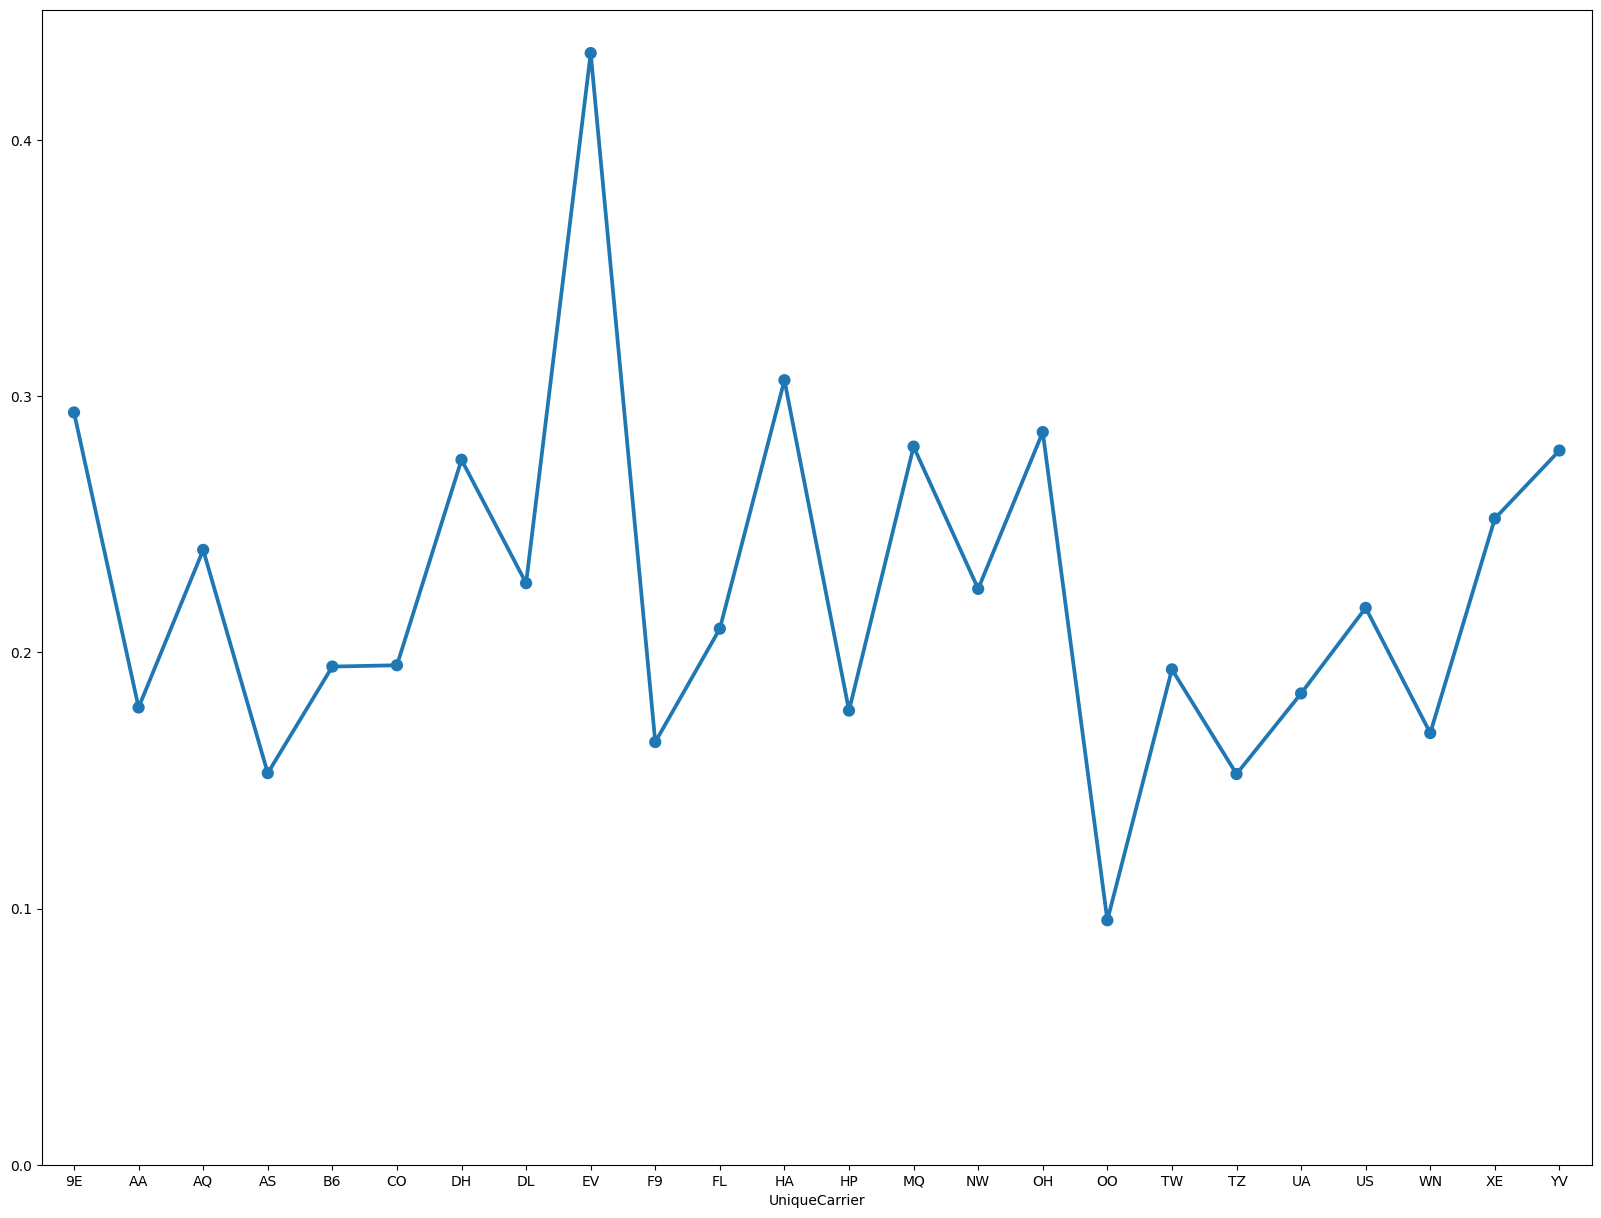

In [52]:
fig = plt.figure(figsize=(20, 15))
ground_time_prop = (df['ActualElapsedTime'] - df['AirTime']) / df['ActualElapsedTime']
ground_time_prop
sns.pointplot(x=df['UniqueCarrier'], y=ground_time_prop, errorbar=None)
plt.ylim(0)
plt.show()

<mark>Findings: `EV` spend the largest portion of its flight process on the ground compared to the other carriers. In contrast, there's `OO` which spends the least time on the ground. This finding could be a measure for each carrier's efficiency in executing flights, but more data is required to propely determine their efficiency, such as the airports they use, or any other limiting factors that a carrier could ecounter.

### 12. Distribution  of flight distance

<AxesSubplot: xlabel='Distance', ylabel='Density'>

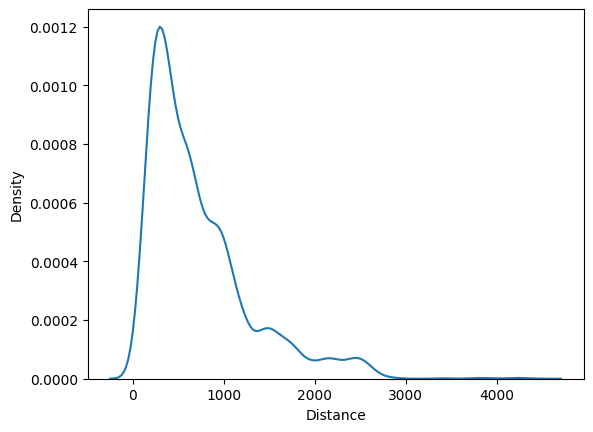

In [74]:
sns.kdeplot(data=df, x='Distance')

<mark>Findings: It is observed that the most probable distances are up to 1000, when larger distances are much less probable, even more so as the distance goes above 3000.

### 13. Cancelled flights prop for each UniqueCarrier

<mark>Using the proportion of cancelled flights 
as a metric of cancellation rather than pure counts is much more reliable, as carriers have widely different total flight counts, as seen before.

<BarContainer object of 24 artists>

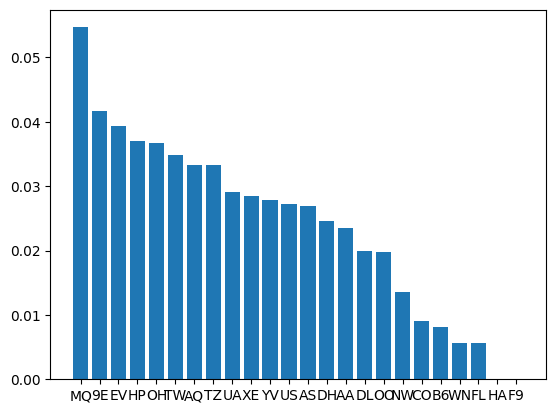

In [75]:
cancel_by_carrier = df.groupby('UniqueCarrier')['Cancelled']
cancel_prop = cancel_by_carrier.sum() / cancel_by_carrier.size()
cancel_prop = cancel_prop.sort_values(ascending=False)
plt.bar(cancel_prop.index, height=cancel_prop)

<mark>Findings: `MQ` has the highest cancellation rate, while `HA` and `F9` has no cancellations over the sampled dataset. This is implies that it is probable that their rate would be the lowest, if not zero, even if the whole dataset would be included, not just 9,000 records.

### 14. Distribution of elapsed time

<AxesSubplot: xlabel='ActualElapsedTime', ylabel='Density'>

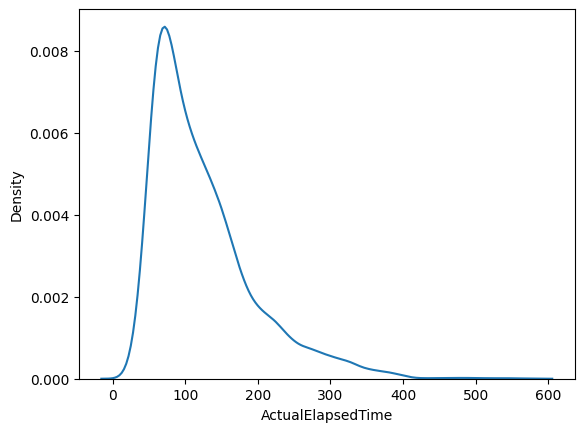

In [73]:
sns.kdeplot(x=df['ActualElapsedTime'])

<mark>Findings: Most flights have elapsed time between 50 to 150. After that, the proportion is only decreasing.

### 15. Mean flight speed by Distance

<mark>This metric is a very intuitive piece of infomation that was not originally included in the dataset.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '(0.0, 1000.0]'),
  Text(1, 0, '(1000.0, 2000.0]'),
  Text(2, 0, '(2000.0, 3000.0]'),
  Text(3, 0, '(3000.0, 4000.0]'),
  Text(4, 0, '(4000.0, 5000.0]')])

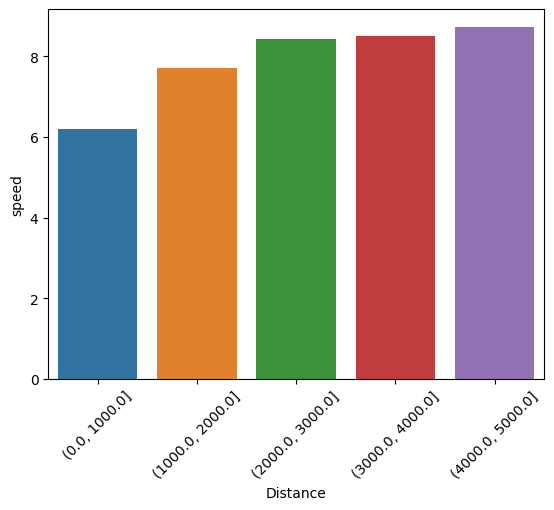

In [55]:
speed = pd.Series(df['Distance'] / df['AirTime'], name='speed')
bins = np.arange(0, df.Distance.max() + 1000, 1000)
cat_distance=pd.cut(x=df.Distance, bins=bins)
sns.barplot(x=cat_distance, y=speed, errorbar=None)
plt.xticks(rotation=45)

<mark>Findings: The avg. speed significantly increases between the three first bins of width 1000km. then, it's barely increasing above 8 km / minute.